In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [3]:
DATA_PATH = '/content/gdrive/MyDrive/Colab Notebooks/data2.json' # path of the file which has the processed data stored in JSON format

def load_data(data_path):
    '''
    function to load data from the JSON file
    param: data_path -> string -> the path of the JSON file which will be used to load data
    return: X -> ndarray -> the extracted input features from the loaded file
            Y -> ndarray -> the expected output for the corresponding inputs in X
    '''
    
    with open(data_path, "r") as fp:
        data = json.load(fp)
    
    # converting list to ndarrays
    X = np.array(data['mfcc'])
    Y = np.array(data['labels'])
    print('Data Loaded Successfully!')
    
    return X, Y

X, Y = load_data(DATA_PATH) # loading data to X and Y

def plot_history(history):
    # function to plot the history of the training of the model
    
    fig, axs = plt.subplots(2)
    
    # plotting accuracy history of training and validation datasets
    axs[0].plot(history.history["accuracy"], label = 'train-accuracy')
    axs[0].plot(history.history["val_accuracy"], label = 'validation-accuracy')
    axs[0].set_ylabel('accuracy')
    axs[0].set_xlabel('epochs')
    axs[0].legend(loc = 'lower right')
    axs[0].set_title('Accuracy Evaluation')
    
    # plotting error history of training and validation datasets
    axs[1].plot(history.history["loss"], label = 'training-loss')
    axs[1].plot(history.history["val_loss"], label = 'validation-loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
    axs[1].legend('upper right')
    axs[1].set_title('Loss Evaluation')
    
    plt.show()
    
def prepare_dataset(validation_size, test_size):
    # function to split the dataset into traning, validation and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = test_size)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    return X_train, X_val, X_test, Y_train, Y_val, Y_test




Data Loaded Successfully!


(5991, 130, 23, 1) (5991,)
(130, 23, 1)
(None, 15, 2, 60)
(None, 15, 120)
(None, 15, 120)
(None, 30)
(None, 10)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 21, 30)       300       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 11, 30)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 64, 11, 30)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 64, 11, 30)       120       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 62, 9, 60)         16260     
        

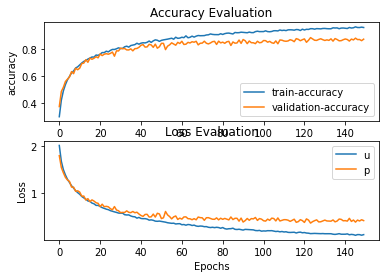

63/63 - 0s - loss: 0.4461 - accuracy: 0.8694 - 203ms/epoch - 3ms/step
Test Accuracy: 0.869369387626648
(9986, 130, 23) (9986,)


In [6]:
def build_model(input_shape):
    # building a RNN-LSTM model
    model = keras.Sequential()
    
    # adding Convolutional layers
    cnn = keras.layers.Conv2D(30, (3, 3), activation = 'relu', input_shape = input_shape)
    model.add(cnn)
    
    cnn = keras.layers.MaxPooling2D((2, 2), padding = 'same')
    model.add(cnn)

    cnn = keras.layers.Dropout(0.1)
    model.add(cnn)
    model.add(keras.layers.BatchNormalization())

    cnn = keras.layers.Conv2D(60, (3, 3), activation = 'relu')
    model.add(cnn)
    
    cnn = keras.layers.MaxPooling2D((3, 3), strides = (2, 2), padding = 'same')
    model.add(cnn)
    
    cnn = keras.layers.Dropout(0.1)
    model.add(cnn)
    model.add(keras.layers.BatchNormalization())

    cnn = keras.layers.Conv2D(60, (3, 3), activation = 'relu')
    model.add(cnn)
    
    cnn = keras.layers.MaxPooling2D((4, 4), strides = (2, 2), padding = 'same')
    model.add(cnn)
    
    cnn = keras.layers.Dropout(0.1)
    model.add(cnn)
    model.add(keras.layers.BatchNormalization())

    output_shape = cnn.output_shape
    print(output_shape)
    
    # reshaping the dimensions to shift from cnn to rnn
    reshape = keras.layers.Reshape(target_shape = (output_shape[1], int(output_shape[2] * output_shape[3])))
    model.add(reshape)
    print(reshape.output_shape)
    
    output_shape = reshape.output_shape
    print(output_shape)
    
    rnn = keras.layers.GRU(30, return_sequences = True)
    model.add(rnn)
    
    rnn = keras.layers.GRU(30)
    model.add(rnn)
    
    last = keras.layers.Dense(10, activation = 'softmax')
    model.add(last)
    
    return model

if(__name__ == '__main__'):
    X_train, X_val, X_test, Y_train, Y_val, Y_test = prepare_dataset(0.25, 0.2)
    print(X_train.shape, Y_train.shape)
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    print(input_shape)
    model = build_model(input_shape)
    
    optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
    
    model.compile(optimizer = optimizer,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    model.summary()
    
    history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size = 32, epochs = 150)
    
    plot_history(history)
    
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose = 2)
    
    print(f'Test Accuracy: {test_acc}')
    
    # X_to_predict = X_test[300]
    # Y_to_predict = Y_test[300]
    
    # predict(model, X_to_predict, Y_to_predict)
    
    print(X.shape, Y.shape)